# CNMOW evaluation results

In [1]:
import json
import os
from os.path import realpath, dirname, join, splitext
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

ROOT = './data/'
OUTPUT_DIR = join(ROOT, 'plots')
os.makedirs(OUTPUT_DIR, exist_ok=True)
baselines = [
    'cbow-784-10p',
    'cmow-784-10p',
    'hybrid-800-10p',   
]

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("PuBuGn_d")

## Benchmark performance

In [ ]:
def extract_values(model_name, row):
    extracted = pd.DataFrame(columns=['Model', 'Benchmark', 'Score'])
    s = pd.Series(index=extracted.columns)
    for k, entry in row.items():
        s['Model'] = model_name
        
        if isinstance(entry, str):
            if entry.lower() == 'none':
                l = (np.nan, np.nan)
                print('Warning: model {} has result "{}" for benchmark {}'.format(model_name, entry, k), 
                      file=sys.stderr)
            else:
                try:
                    l = json.loads(entry.replace('(', '[').replace(')', ']'))
                except json.JSONDecodeError as e:
                    print('For model {}, could not extract pair from entry: {}'.format(
                        model_name, entry))
                    raise e
            # Pairs of numbers represent (spearman, pearson)
            s['Benchmark'] = k + '\nspearman'
            s['Score'] = float(l[0])
            extracted = extracted.append(s, ignore_index=True)
            #s['Benchmark'] = k + ' - pearson'
            #s['Score'] = float(l[1])
            #extracted = extracted.append(s, ignore_index=True)
        else:
            s['Benchmark'] = k
            s['Score'] = entry
            extracted = extracted.append(s, ignore_index=True)
    return extracted

def extract_model_name(row):
    import json
    n = row['outputmodelname']
    try:
        s = json.loads(n.replace("'", '"'))
        return s[0]
    except ValueError as e:
        print(e)
        pass
    return n

def plot_evaluation_results(eval_filenames, baselines=None, filename='comparison.pdf'):
    extracted = None
    model_names = {}
    for fname in eval_filenames:
        df = pd.read_csv(fname, sep=';', header=0)
        for i, row in df.iterrows():
            evals = json.loads(row['downstream_tasks'].replace("'", '"'))
            # There's one model per row
            model_name = extract_model_name(row)
            if model_name in model_names:
                print('Model name "{}" seen in two files: \n- {}\n- {}'.format(
                    model_name, fname, model_names[model_name]
                ), file=sys.stderr)
            model_names[model_name] = fname
            ee = extract_values(model_name, row[evals])
            if extracted is None:
                extracted = ee
            else:
                extracted = extracted.append(ee)
          
    fig, ax = plt.subplots(2, 1, figsize=(16, 2*7))
    for i, coeff_metrics in enumerate([False, True]):
        mask = extracted['Benchmark'].str.contains("spearman|pearson")
        if not coeff_metrics:
            mask = ~mask
        selected = extracted[mask]
        benchmarks = sorted(selected['Benchmark'].unique())
        
        sns.barplot(x='Benchmark', y='Score', hue='Model', data=selected, order=benchmarks, ax=ax[i])
        ax[i].set_title('Evaluation results on several variants')
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, horizontalalignment='right')
        
        if baselines is not None:
            baseline_mask = selected['Model'].str.match('|'.join(baselines))
            baseline_results = selected[baseline_mask]
            # Draw the high-line for each metric (whichever baseline is best for that metric)
            length = (ax[i].get_xlim()[1] - ax[i].get_xlim()[0]) / len(benchmarks)
            for j, bench in enumerate(benchmarks):
                max_val = baseline_results[baseline_results['Benchmark'] == bench]['Score'].max()
                ax[i].plot([length*(j-0.5), length*(j+0.5)], [max_val, max_val], '-k', alpha=0.35)
        
    plt.tight_layout()
    out = join(OUTPUT_DIR, filename)
    plt.savefig(out, bbox_inches='tight', dpi=128)
    plt.savefig(splitext(out)[0] + '.png', bbox_inches='tight', dpi=200)

In [ ]:
sources = [
    './evaluation-cbow-784-10p/evaluation.csv',
    './evaluation-cmow-784-10p/evaluation.csv',
    './evaluation-hybrid-800-10p/evaluation.csv',
    
    './evaluation-cnmow1-784-10p/evaluation.csv',
    './evaluation-cnmow1b-784-10p/evaluation.csv',
    './evaluation-cnmow2-784-10p/evaluation.csv',
    './evaluation-cnmow2b-784-10p/evaluation.csv',
    './evaluation-cnmow5-784-10p/evaluation.csv',
    './evaluation-cnmow5-hybrid-800-10p/evaluation.csv',
    './evaluation-cnmow6-784-10p/evaluation.csv',
    './evaluation-cnmow6-hybrid-800-10p/evaluation.csv',
    './evaluation-cnmow8-784-10p/evaluation.csv',
    './evaluation-cnmow9-784-10p/evaluation.csv',
]
plot_evaluation_results([join(ROOT, source) for source in sources], baselines=baselines,
                        filename='comparison-all.pdf')

In [ ]:
sources = [
    './evaluation-hybrid-800-10p/evaluation.csv',
    './evaluation-cnmow5-hybrid-800-10p/evaluation.csv',
    './evaluation-cnmow6-hybrid-800-10p/evaluation.csv',
]
plot_evaluation_results([join(ROOT, source) for source in sources], baselines=baselines,
                        filename='comparison-hybrid.pdf')

In [ ]:
# TODO: actually pick the best models
sources = [
    './evaluation-cbow-784-10p/evaluation.csv',
    './evaluation-cmow-784-10p/evaluation.csv',
    './evaluation-hybrid-800-10p/evaluation.csv',
    
    './evaluation-cnmow1-784-10p/evaluation.csv',
    './evaluation-cnmow6-hybrid-800-10p/evaluation.csv',
]
plot_evaluation_results([join(ROOT, source) for source in sources], baselines=baselines,
                        filename='comparison-best.pdf')

## Training times

In [ ]:
import csv

def parse_training_metadata(filenames):
    if not isinstance(filenames, (list, tuple)):
        filenames = [filenames]
        
    df = pd.DataFrame(columns=['Variant name', 'Docs count', 'Training time', 'Epoch count'])
    
    for fname in filenames:
        parsed = pd.read_csv(fname, sep=',', usecols=(0,1,2,3), header=0, index_col=False, 
                             squeeze=True, skipinitialspace=True)
        df = df.append(parsed, ignore_index=True)
        
    # Mark invalid data with NaN
    df['Training time'] = df['Training time'].where(lambda v: v > 1)
    df['Epoch count'] = df['Epoch count'].where(lambda v: v > 1)
    df['Sentence / second'] = df['Docs count'] * df['Epoch count'] / df['Training time']
    return df
        
    
def plot_training_metadata(df, baselines=None, filename='training-times.pdf'):
    fig, ax = plt.subplots(3, 1, figsize=(16, 3*7))
    for i, metric in enumerate(['Training time', 'Epoch count', 'Sentence / second']):
        sns.barplot(x='Variant name', y=metric, data=df, ax=ax[i])
        #ax[i].set_title(metric)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, horizontalalignment='right')
        ax[i].set_xlabel('')
        
        if i == 0:
            ax[i].set_ylim((0, 25000))
        
    plt.tight_layout()
    out = join(OUTPUT_DIR, filename)
    plt.savefig(out, bbox_inches='tight', dpi=128)
    plt.savefig(splitext(out)[0] + '.png', bbox_inches='tight', dpi=200)

In [ ]:
models_trained = [
    './model-cbow-784-10p/metadata.csv',
    './model-cmow-784-10p/metadata.csv',
    './model-hybrid-800-10p/metadata.csv',
    './model-cnmow1-784-10p/metadata.csv',
    './model-cnmow1b-784-10p/metadata.csv',
    './model-cnmow2-784-10p/metadata.csv',
    './model-cnmow2b-784-10p/metadata.csv',
#     './model-cnmow3-784-10p/metadata.csv',
    './model-cnmow5-784-10p/metadata.csv',
    './model-cnmow5-hybrid-800-10p/metadata.csv',
    './model-cnmow6-784-10p/metadata.csv',
    './model-cnmow6b-784-10p/metadata.csv',
    './model-cnmow6-hybrid-800-10p/metadata.csv',
    './model-cnmow8-784-10p/metadata.csv',
    './model-cnmow9-784-10p/metadata.csv',
]

df = parse_training_metadata([join(ROOT, source) for source in models_trained])
plot_training_metadata(df)

# Hyperparameter tuning

In [2]:
data_alpha = np.genfromtxt('EE_3_val_loss.csv',delimiter=',')

In [4]:
alphas = [1,2,4,8,16,32,64]

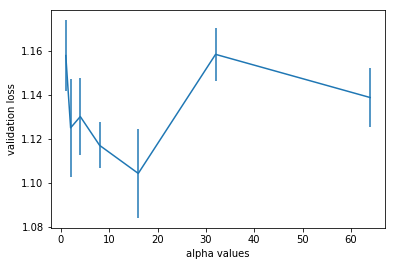

In [20]:
plt.errorbar(alphas,np.mean(data_alpha,axis=1),yerr=(1/np.sqrt(10))*np.std(data_alpha,axis=1))
plt.xlabel('alpha values')
plt.ylabel('validation loss')
plt.show()

In [10]:
lamb_1 = np.genfromtxt('lambV2_val_loss.csv',delimiter=',')
lamb_2 = np.genfromtxt('lambV2_2_val_loss.csv',delimiter=',')
lamb_3 = np.genfromtxt('lambV2_3_val_loss.csv',delimiter=',')

In [11]:
lambdas = [0,0.25,0.5,0.75,1.0]

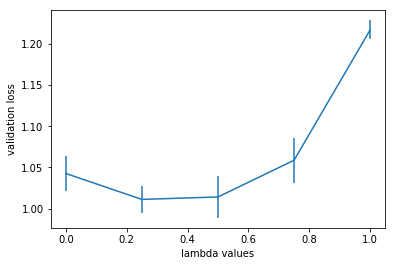

In [14]:
plt.errorbar(lambdas,np.mean(lamb_1,axis=1),yerr=(1.96/np.sqrt(10))*np.std(lamb_1,axis=1))
plt.xlabel('lambda values')
plt.ylabel('validation loss')
plt.show()

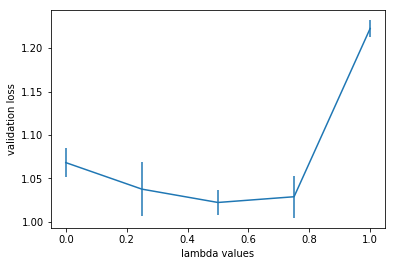

In [17]:
plt.errorbar(lambdas,np.mean(lamb_2,axis=1),yerr=(1.96/np.sqrt(10))*np.std(lamb_2,axis=1))
plt.xlabel('lambda values')
plt.ylabel('validation loss')
plt.show()

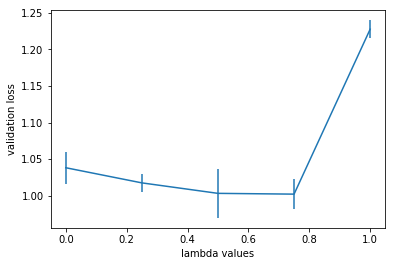

In [18]:
plt.errorbar(lambdas,np.mean(lamb_3,axis=1),yerr=(1.96/np.sqrt(10))*np.std(lamb_3,axis=1))
plt.xlabel('lambda values')
plt.ylabel('validation loss')
plt.show()

In [19]:
np.mean(lamb_3,axis=1)

array([1.038198, 1.017468, 1.003142, 1.002079, 1.227717])